# Quality Check

To assess that the data has been loaded correctly, I'm going to verify that there are no corrupted values and that the dimensions, columns, and rows correspond with the right format.

In [1]:
import configparser
from datetime import datetime
import boto3, os
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, dayofweek, date_format

import matplotlib.pyplot as plt 

In [2]:
spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()

In [3]:
output_data = "s3a://capstone-project-udaz/Output_Data/"

I'll display the structure of the tables in our Data Lake to confirm that the ETL has worked properly.

In [4]:
# Countries table
countries_df = spark.read.parquet(os.path.join(output_data, "countries/*.parquet"))

In [5]:
countries_df.show(5)

+------------+--------------------+
|country_code|             country|
+------------+--------------------+
|         COD|Democratic Republ...|
|         VGB|British Virgin Is...|
|         BIH|Bosnia and Herzeg...|
|         ARE|United Arab Emirates|
|         CIV|       Cote d'Ivoire|
+------------+--------------------+
only showing top 5 rows



In [6]:
# Time table
time_df = spark.read.parquet(os.path.join(output_data, "times/*.parquet"))

In [7]:
stocks_df = spark.read.parquet(os.path.join(output_data, "stocks/*.parquet")).show()

+--------+--------------------+--------------------+
|stock_id|        company_name|              sector|
+--------+--------------------+--------------------+
|  ALL.AX|  Aristocrat Leisure|Consumer Discreti...|
|   BKG.L|Berkeley Group Ho...|Consumer Discreti...|
|     EFX|        Equifax Inc.|         Industrials|
|     FLS|Flowserve Corpora...|         Industrials|
|     IFF|International Fla...|           Materials|
|   KL.TO|Kirkland Lake Gol...|           Materials|
|  LIN.DE|               Linde|           Materials|
| MUV2.DE|           Munich Re|          Financials|
|   NA.TO|National Bank of ...|          Financials|
|  NAB.AX|National Australi...|          Financials|
|  NZX.NZ|         NZX Limited|          Financials|
|   PNN.L|        Pennon Group|  Consumer Defensive|
|     REG|Regency Centers C...|         Real Estate|
|RRR1R.RG|AS VEF Radiotehni...|Information Techn...|
|  STO.AX|              Santos|              Energy|
|     TEL|TE Connectivity Ltd.|Information Tec

In [8]:
# Ec_status table (fact table)
Ec_status_df = spark.read.parquet(os.path.join(output_data, "Ec_status/*.parquet"))

In [9]:
Ec_status_df.printSchema()

root
 |-- ec_status_id: long (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- country_code: string (nullable = true)
 |-- stringency_index: double (nullable = true)
 |-- stock_id: string (nullable = true)
 |-- value_type: string (nullable = true)
 |-- value: double (nullable = true)



In [10]:
Ec_status_df.show(5)

+------------+-------------------+------------+----------------+--------+----------+------------------+
|ec_status_id|               date|country_code|stringency_index|stock_id|value_type|             value|
+------------+-------------------+------------+----------------+--------+----------+------------------+
|         199|2019-09-23 00:00:00|         FRA|             0.0|   AI.PA| Adj Close| 115.6096420288086|
|         223|2019-09-23 00:00:00|         TUR|             0.0|ALGYO.IS| Adj Close| 7.978088855743408|
|         550|2019-09-23 00:00:00|         USA|             0.0|     DHR| Adj Close|143.78990173339844|
|         689|2019-09-23 00:00:00|         USA|             0.0|     FMC| Adj Close| 86.64683532714844|
|         970|2019-09-23 00:00:00|         DEU|             0.0|  LIN.DE| Adj Close| 171.9288330078125|
+------------+-------------------+------------+----------------+--------+----------+------------------+
only showing top 5 rows



In [11]:
# Checking duplicates
if Ec_status_df.count() > Ec_status_df.dropDuplicates(Ec_status_df.columns).count():
    raise ValueError('Data has duplicates')
else:
    print("Data has no duplicates")

Data has no duplicates


In [12]:
#  Check for missing values
from pyspark.sql.functions import isnan, when, count, col
Ec_status_df.select([count(when(col(c).isNull(), c)).alias(c) for c in Ec_status_df.columns]).show()

+------------+----+------------+----------------+--------+----------+-----+
|ec_status_id|date|country_code|stringency_index|stock_id|value_type|value|
+------------+----+------------+----------------+--------+----------+-----+
|           0|   0|           0|               0|       0|         0|    0|
+------------+----+------------+----------------+--------+----------+-----+



Let's check that we have all the countries in our final fact table.

In [13]:
countries = Ec_status_df.select('country_code')
# countries.distinct().show()
countries.distinct().count()

49

We can see that in this case we have 49 countries when our original file _Stock_Countries.csv_ had 50. This is because when collecting the stock market values _yfinance_ library couldn't get any of the 25 values of the companies in _Greece_. This is not a problem because it can be fixed in time (if yahoo finances updates stock market of the companies for the next days) or if we change the date range selected.

## Example

This example will serve as a small presentation on how this data lake can be useful to analyze the economic impact of the measures took by goverments in regards to fight covid-19.

In [14]:
Ec_status_df.filter((Ec_status_df.country_code=='ESP') & (Ec_status_df.value_type=='Open') & (Ec_status_df.stock_id=='TRE.MC')).sort("Date").show()

+------------+-------------------+------------+----------------+--------+----------+------------------+
|ec_status_id|               date|country_code|stringency_index|stock_id|value_type|             value|
+------------+-------------------+------------+----------------+--------+----------+------------------+
|  8590345387|2019-09-23 00:00:00|         ESP|             0.0|  TRE.MC|      Open| 23.15999984741211|
|  8590347242|2019-09-24 00:00:00|         ESP|             0.0|  TRE.MC|      Open|23.139999389648438|
|  8590349098|2019-09-25 00:00:00|         ESP|             0.0|  TRE.MC|      Open|23.040000915527344|
|  8590350954|2019-09-26 00:00:00|         ESP|             0.0|  TRE.MC|      Open|22.459999084472656|
|  8590352735|2019-09-27 00:00:00|         ESP|             0.0|  TRE.MC|      Open|22.239999771118164|
|  8590354585|2019-09-30 00:00:00|         ESP|             0.0|  TRE.MC|      Open|22.399999618530273|
|  8590356381|2019-10-01 00:00:00|         ESP|             0.0|

In [15]:
spain_df_p = Ec_status_df.filter((Ec_status_df.country_code=='ESP') & (Ec_status_df.value_type=='Open') & (Ec_status_df.stock_id=='TRE.MC')).sort("Date").toPandas()

In [16]:
spain_df_p.head(5)

,ec_status_id,date,country_code,stringency_index,stock_id,value_type,value
0,8590345387,2019-09-23,ESP,0.0,TRE.MC,Open,23.160000
1,8590347242,2019-09-24,ESP,0.0,TRE.MC,Open,23.139999
2,8590349098,2019-09-25,ESP,0.0,TRE.MC,Open,23.040001
3,8590350954,2019-09-26,ESP,0.0,TRE.MC,Open,22.459999
4,8590352735,2019-09-27,ESP,0.0,TRE.MC,Open,22.240000


In [17]:
spain_df_p.dtypes

ec_status_id                 int64
date                datetime64[ns]
country_code                object
stringency_index           float64
stock_id                    object
value_type                  object
value                      float64
dtype: object

In [18]:
plt.clf()

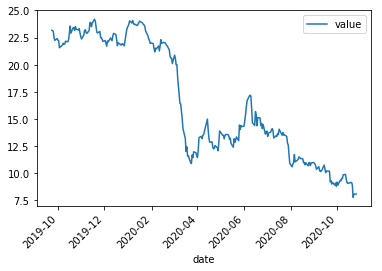

In [19]:
spain_df_p.plot(x='date', y=['value'], kind='line', rot=45)

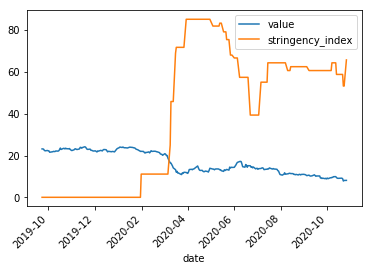

In [20]:
spain_df_p.plot(x='date', y=['value', 'stringency_index'], kind='line', rot=45)

It is possible to appreciate it with more detail if I normalize _stringency_index_ value to the stock market value.

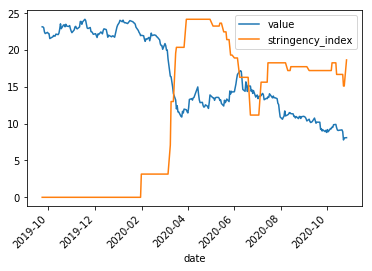

In [21]:
spain_df_p['stringency_index'] = (spain_df_p['stringency_index']/spain_df_p['stringency_index'].max())*spain_df_p['value'].max()
spain_df_p.plot(x='date', y=['value', 'stringency_index'], kind='line', rot=45)

We can appreciate in this example how the stringency of the measures took by the goverment are greatly correlated with the stock market value for this company.

In the same way we can assess the economic impact on an entire country, different regions, filter by sectors, filter by date...

This Data Lake allow us to develop a very useful tool to assess the real economic impact of covid-19.

***